In [1]:
import logging
import math
import random
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
class MyParameters(object):
  logging = 'INFO'
  embedding_dim = 100
  num_hidden = 100
  num_layers = 2
  dropout = 0.3
  epochs = 20
  num_steps = 30
  batch_size = 20
  lr = 0.001
  clip_val = 1

In [4]:
class Vocab(object):
    """ Converts word tokens to indices, and vice versa. """

    def __init__(self):
        super().__init__()

        self.tok_to_ind = {}
        self.ind_to_tok = []
        self.counts = []

    def add(self, word):
        """ Adds the given word to the dict, or increases it's
        count if already present. Returns it's index.
        """
        ind = self.tok_to_ind.get(word, None)
        
        if ind is None:
          ind = len(self.ind_to_tok)
          self.ind_to_tok.append(word)
          self.tok_to_ind[word] = ind
          self.counts.append(1)
        else: self.counts[ind] += 1
        
        return ind

    def __len__(self):
        return len(self.tok_to_ind)

In [5]:
base_path = "/content/drive/MyDrive/NLP_HW2"

In [6]:
def path(part):
    """ Gets the dataset for 'part' being train|test|valid. 
    The dataset is uploaded on Google Colab, if using a different directory update return of the function. 
    """
    assert part in ("train", "test", "valid")
    return os.path.join(base_path, "wiki." + part + ".txt")


def load(path, index):
    """ Loads the wikitext2 data at the given path using
    the given index (maps tokens to indices). Returns
    a list of sentences where each is a list of token
    indices.
    """
    sentences = []
    with open(path, "r") as f:
      for para in f:
        words = para.split()
        for i in range(0, len(words), params.num_steps):
          tokens = words[i:i+params.num_steps]
          if not tokens:
            continue
          sentence = [vocab.add(t.lower()) for t in tokens]
          sentences.append(sentence)
    sentences = [x for x in sentences if len(x) > 1]
    return sentences

In [7]:
def softmax(x):
    """Compute softmax values from scratch using torch."""
    return torch.exp(x) / torch.exp(x).sum(1, keepdim=True)

In [8]:
def nll_loss(pred, actual):
    """ Function to calculate negative log-likelihood loss."""
    op = torch.diag(pred[:,actual])
    return -torch.mean(op)

In [33]:
class LstmLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_dim, num_layers, dropout):
        super(LstmLM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, vocab_size)
        self.initialize_lstm_weights()
        self.initialize_fc_weights()

    def get_embedding(self, word_indexes):
        return self.fc1.weight.index_select(0, word_indexes)

    def forward(self, packed_sents):
        embedding = nn.utils.rnn.PackedSequence(
            self.get_embedding(packed_sents.data), packed_sents.batch_sizes)
        out_seq, _ = self.lstm(embedding)
        out = self.fc1(out_seq.data)
        return torch.log(softmax(out))

    def initialize_lstm_weights(self):
      print('initializing lstm weights')
      for cur_layer in self.lstm._all_weights:
        for cur_weight_type in cur_layer:
          if 'weight' in cur_weight_type:
            nn.init.uniform_(self.lstm.__getattr__(cur_weight_type), -0.1, 0.1)
            

    def initialize_fc_weights(self):
      print('initializing fc weights')
      nn.init.uniform_(self.fc1.weight, -0.1, 0.1)


In [25]:
def batch_split(txt, batch_size):
    random.shuffle(txt)
    for i in range(0, len(txt), batch_size):
        sentences = txt[i:i + batch_size]
        sentences.sort(key=lambda l: len(l), reverse=True)
        yield [torch.LongTensor(s) for s in sentences]


def iterate(model, sents, device):
    x = nn.utils.rnn.pack_sequence([s[:-1] for s in sents])
    y = nn.utils.rnn.pack_sequence([s[1:] for s in sents])
    if device.type == 'cuda':
        x, y = x.cuda(), y.cuda()
    out = model(x)
    out = torch.log(softmax(out))
    loss = nll_loss(out, y.data)
    return out, loss, y


def train(data, model, optimizer, params, device):
    model.train()
    for batch_ind, sents in enumerate(batch_split(data, params.batch_size)):
        model.zero_grad()
        out, loss, y = iterate(model, sents, device)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), params.clip_val)
        optimizer.step()
        if batch_ind == 0:
            # Calculate perplexity for first batch.
            perplexity = torch.exp(loss)
    return loss.item(), perplexity.item()

def perplexity_calc(data, model, batch_size, device):
    """ Perplexity calculation for validation and test data """
    model.eval()
    with torch.no_grad():
        sum_probs = 0
        word_cnt = 0
        for sents in batch_split(data, batch_size):
            out, _, y = iterate(model, sents, device)
            prob = out.exp()[
                torch.arange(0, y.data.shape[0], dtype=torch.int64), y.data]
            sum_probs += prob.log2().neg().sum().item()
            word_cnt += y.data.shape[0]
    return 2 ** (sum_probs / word_cnt)

In [26]:
def main(params):
    logging.basicConfig(level=params.logging)

    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
    model = LstmLM(len(vocab), params.embedding_dim,
                  params.num_hidden, params.num_layers, params.dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params.lr)
    pp_train_lst = []
    pp_val_lst = []
    pp_test_lst = []
    for epoch_ind in range(params.epochs):
        logging.info("Training epoch %d", epoch_ind)
        loss_item, pp_train = train(train_data, model, optimizer, params, device)
        logging.info("Batch %d, loss %.3f, perplexity %.2f", 1, loss_item, pp_train)
        pp_train_lst.append(pp_train)
        pp_val = perplexity_calc(valid_data, model, params.batch_size, device)
        logging.info("Validation perplexity: %.1f", pp_val)
        pp_val_lst.append(pp_val)
        pp_test = perplexity_calc(test_data, model, params.batch_size, device)
        logging.info("Test perplexity: %.1f", pp_test)
        pp_test_lst.append(pp_test)
    
    x_side = [x for x in range(1,len(pp_train_lst))]
    plt.plot(x_side, pp_train_lst[1:], label='train_perplexity')
    plt.plot(x_side, pp_val_lst[1:], label='validation_perplexity')
    plt.plot(x_side, pp_test_lst[1:], label='test_perplexity')
    plt.legend()
    plt.show()

In [27]:
params = MyParameters()
vocab = Vocab()
# Load data and convert to numeric representation
train_data = load(path("train"), vocab)
valid_data = load(path("valid"), vocab)
test_data = load(path("test"), vocab)

INFO:root:Training epoch 0


initializing lstm weights
initializing fc weights


INFO:root:Batch 1, loss 6.078, perplexity 29043.59
INFO:root:Validation perplexity: 380.3
INFO:root:Test perplexity: 358.1
INFO:root:Training epoch 1
INFO:root:Batch 1, loss 5.869, perplexity 446.47
INFO:root:Validation perplexity: 265.7
INFO:root:Test perplexity: 250.4
INFO:root:Training epoch 2
INFO:root:Batch 1, loss 5.768, perplexity 368.46
INFO:root:Validation perplexity: 227.8
INFO:root:Test perplexity: 214.7
INFO:root:Training epoch 3
INFO:root:Batch 1, loss 5.829, perplexity 241.70
INFO:root:Validation perplexity: 205.9
INFO:root:Test perplexity: 192.6
INFO:root:Training epoch 4
INFO:root:Batch 1, loss 5.076, perplexity 187.23
INFO:root:Validation perplexity: 193.5
INFO:root:Test perplexity: 181.9
INFO:root:Training epoch 5
INFO:root:Batch 1, loss 4.927, perplexity 175.03
INFO:root:Validation perplexity: 185.5
INFO:root:Test perplexity: 173.7
INFO:root:Training epoch 6
INFO:root:Batch 1, loss 5.032, perplexity 134.75
INFO:root:Validation perplexity: 179.4
INFO:root:Test perplex

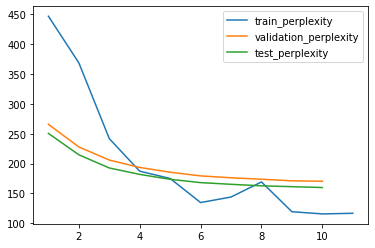

In [34]:
main(params)